# Import Libraries 

In [1]:
from tqdm import tqdm
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from   torchvision import datasets, transforms
import torch.optim as optim
from   torch.optim.lr_scheduler import StepLR
from   torchinfo import summary

import albumentations as A
from   albumentations.pytorch import ToTensorV2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import models as cifar_models
import utils as myutils

# Set the GPU device

In [2]:
# Is GPU available
device = torch.device("cpu")
is_gpu_available = False

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda:0")
    is_gpu_available = True
elif torch.backends.mps.is_available():
    print("Apple MPS is available")
    device = torch.device("mps:0")
    is_gpu_available = True

torch.set_default_device(device)

Apple MPS is available


# Download and prepare the dataset

In [3]:
# To get over the following error:
# URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
batch_size = 2048
# Train Phase transformations
train_transforms = myutils.Transforms(transforms=A.Compose([
    A.HorizontalFlip(p=0.25),
    A.ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, 
        border_mode=4, value=None, mask_value=None, shift_limit_x=None, shift_limit_y=None, 
        rotate_method='largest_box', always_apply=False, p=0.5,
    ),
    A.CoarseDropout(
        max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
        min_width=16, fill_value=0.48, mask_fill_value=None, always_apply=False, p=0.5,
    ),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(),
]))

# Test Phase transformations
test_transforms = myutils.Transforms(transforms=A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(),
]))

# Data
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# Data loaders
dataloader_args = dict(shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True) if is_gpu_available else dict(shuffle=True, batch_size=64)

# train dataloader
train_data_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)
# test dataloader
test_data_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

print("classes: ", train_data.class_to_idx)
# {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
classes:  {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


## Look at the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['image'])


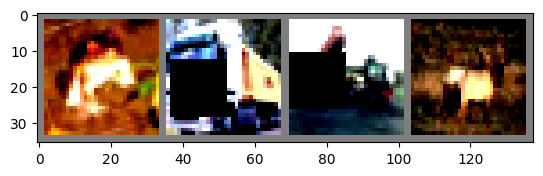

frog  truck truck deer 


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_data_loader)
data, labels = next(dataiter)
print(data.keys())
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
imshow(torchvision.utils.make_grid(data['image'][:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Model

# Summary

In [6]:
model = cifar_models.Net().to(device)
summary(model=model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           4,736
│    └─ReLU: 2-2                         [1, 32, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 32, 32, 32]           64
│    └─Dropout: 2-4                      [1, 32, 32, 32]           --
├─Sequential: 1-2                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 32, 32, 32]           832
│    └─ReLU: 2-6                         [1, 32, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 32, 32, 32]           64
│    └─Dropout: 2-8                      [1, 32, 32, 32]           --
├─Sequential: 1-3                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-9                       [1, 64, 32, 32]           2,112
│    └─R

# Train and test the model

In [7]:
model = cifar_models.Net().to(device)

criterion = F.nll_loss
optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 100
for epoch in range(EPOCHS):
    # Train
    train_epoch_accuracy = myutils.train(model, train_data_loader, criterion, optimizer, epoch, train_losses, train_acc, device)
    # scheduler.step()
    # Test
    test_epoch_accuracy = myutils.test(model, test_data_loader, epoch, test_losses, test_acc, device)
    # 
    if train_epoch_accuracy >= 85 or test_epoch_accuracy >= 85:
        break

Epoch=0 Batch_id=24 Loss=2.0291836261749268 Accuracy=19.17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.59s/it]



Test set: Average loss: 2.1221, Accuracy: 1704/10000 (17.04%)



Epoch=1 Batch_id=24 Loss=1.904832124710083 Accuracy=26.33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.8918, Accuracy: 2785/10000 (27.85%)



Epoch=2 Batch_id=24 Loss=1.8300158977508545 Accuracy=30.62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.7894, Accuracy: 3345/10000 (33.45%)



Epoch=3 Batch_id=24 Loss=1.7633017301559448 Accuracy=32.86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.7351, Accuracy: 3606/10000 (36.06%)



Epoch=4 Batch_id=24 Loss=1.7481939792633057 Accuracy=34.94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.6942, Accuracy: 3822/10000 (38.22%)



Epoch=5 Batch_id=24 Loss=1.6908162832260132 Accuracy=36.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.6447, Accuracy: 4025/10000 (40.25%)



Epoch=6 Batch_id=24 Loss=1.667470097541809 Accuracy=37.32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.6161, Accuracy: 4113/10000 (41.13%)



Epoch=7 Batch_id=24 Loss=1.6590449810028076 Accuracy=38.46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.5869, Accuracy: 4207/10000 (42.07%)



Epoch=8 Batch_id=24 Loss=1.6652472019195557 Accuracy=38.92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.5494, Accuracy: 4329/10000 (43.29%)



Epoch=9 Batch_id=24 Loss=1.6225330829620361 Accuracy=40.10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:58<00:00,  4.75s/it]



Test set: Average loss: 1.5496, Accuracy: 4364/10000 (43.64%)



Epoch=10 Batch_id=24 Loss=1.5955089330673218 Accuracy=41.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.4976, Accuracy: 4604/10000 (46.04%)



Epoch=11 Batch_id=24 Loss=1.613754391670227 Accuracy=41.52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.4703, Accuracy: 4668/10000 (46.68%)



Epoch=12 Batch_id=24 Loss=1.5565968751907349 Accuracy=42.55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.4509, Accuracy: 4768/10000 (47.68%)



Epoch=13 Batch_id=24 Loss=1.5619384050369263 Accuracy=42.77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.4537, Accuracy: 4742/10000 (47.42%)



Epoch=14 Batch_id=24 Loss=1.551984190940857 Accuracy=43.16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.4290, Accuracy: 4850/10000 (48.50%)



Epoch=15 Batch_id=24 Loss=1.5366548299789429 Accuracy=43.68: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.4352, Accuracy: 4814/10000 (48.14%)



Epoch=16 Batch_id=24 Loss=1.5007582902908325 Accuracy=44.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.4033, Accuracy: 4977/10000 (49.77%)



Epoch=17 Batch_id=24 Loss=1.4840630292892456 Accuracy=44.62: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.3835, Accuracy: 5096/10000 (50.96%)



Epoch=18 Batch_id=24 Loss=1.5212266445159912 Accuracy=45.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.3861, Accuracy: 5082/10000 (50.82%)



Epoch=19 Batch_id=24 Loss=1.491409420967102 Accuracy=45.43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [17:28<00:00, 41.95s/it]



Test set: Average loss: 1.4094, Accuracy: 5013/10000 (50.13%)



Epoch=20 Batch_id=24 Loss=1.5107142925262451 Accuracy=45.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [16:21<00:00, 39.27s/it]



Test set: Average loss: 1.4064, Accuracy: 5046/10000 (50.46%)



Epoch=21 Batch_id=24 Loss=1.4688305854797363 Accuracy=46.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.3915, Accuracy: 5018/10000 (50.18%)



Epoch=22 Batch_id=24 Loss=1.4691764116287231 Accuracy=46.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [16:20<00:00, 39.24s/it]



Test set: Average loss: 1.3766, Accuracy: 5089/10000 (50.89%)



Epoch=23 Batch_id=24 Loss=1.4535191059112549 Accuracy=46.76: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.3619, Accuracy: 5121/10000 (51.21%)



Epoch=24 Batch_id=24 Loss=1.4311801195144653 Accuracy=47.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.3330, Accuracy: 5212/10000 (52.12%)



Epoch=25 Batch_id=24 Loss=1.437089443206787 Accuracy=47.26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.3440, Accuracy: 5230/10000 (52.30%)



Epoch=26 Batch_id=24 Loss=1.461600661277771 Accuracy=47.37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [04:08<00:00,  9.94s/it]



Test set: Average loss: 1.3200, Accuracy: 5302/10000 (53.02%)



Epoch=27 Batch_id=24 Loss=1.419451117515564 Accuracy=48.02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.3188, Accuracy: 5298/10000 (52.98%)



Epoch=28 Batch_id=24 Loss=1.4162646532058716 Accuracy=48.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [15:43<00:00, 37.73s/it]



Test set: Average loss: 1.3175, Accuracy: 5295/10000 (52.95%)



Epoch=29 Batch_id=24 Loss=1.3972840309143066 Accuracy=48.86: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.46s/it]



Test set: Average loss: 1.3162, Accuracy: 5289/10000 (52.89%)



Epoch=30 Batch_id=24 Loss=1.4062660932540894 Accuracy=48.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [16:44<00:00, 40.19s/it]



Test set: Average loss: 1.3247, Accuracy: 5289/10000 (52.89%)



Epoch=31 Batch_id=24 Loss=1.4164962768554688 Accuracy=48.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.46s/it]



Test set: Average loss: 1.2954, Accuracy: 5376/10000 (53.76%)



Epoch=32 Batch_id=24 Loss=1.3882912397384644 Accuracy=48.65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [17:04<00:00, 41.00s/it]



Test set: Average loss: 1.3335, Accuracy: 5216/10000 (52.16%)



Epoch=33 Batch_id=24 Loss=1.3846734762191772 Accuracy=49.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.2917, Accuracy: 5392/10000 (53.92%)



Epoch=34 Batch_id=24 Loss=1.3743098974227905 Accuracy=49.80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [15:56<00:00, 38.27s/it]



Test set: Average loss: 1.2929, Accuracy: 5374/10000 (53.74%)



Epoch=35 Batch_id=24 Loss=1.3434081077575684 Accuracy=50.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.2849, Accuracy: 5445/10000 (54.45%)



Epoch=36 Batch_id=24 Loss=1.3649165630340576 Accuracy=50.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.2744, Accuracy: 5448/10000 (54.48%)



Epoch=37 Batch_id=24 Loss=1.357703685760498 Accuracy=50.14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.2738, Accuracy: 5454/10000 (54.54%)



Epoch=38 Batch_id=24 Loss=1.3732426166534424 Accuracy=50.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [15:44<00:00, 37.77s/it]



Test set: Average loss: 1.2869, Accuracy: 5440/10000 (54.40%)



Epoch=39 Batch_id=24 Loss=1.354146957397461 Accuracy=50.50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.2714, Accuracy: 5455/10000 (54.55%)



Epoch=40 Batch_id=24 Loss=1.3499830961227417 Accuracy=50.63: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [16:37<00:00, 39.91s/it]



Test set: Average loss: 1.2903, Accuracy: 5411/10000 (54.11%)



Epoch=41 Batch_id=24 Loss=1.2999684810638428 Accuracy=51.26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.2705, Accuracy: 5533/10000 (55.33%)



Epoch=42 Batch_id=24 Loss=1.3310354948043823 Accuracy=51.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.2557, Accuracy: 5532/10000 (55.32%)



Epoch=43 Batch_id=24 Loss=1.339653730392456 Accuracy=51.61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.2430, Accuracy: 5590/10000 (55.90%)



Epoch=44 Batch_id=24 Loss=1.336757779121399 Accuracy=51.94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.2430, Accuracy: 5583/10000 (55.83%)



Epoch=45 Batch_id=24 Loss=1.3360614776611328 Accuracy=51.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.2282, Accuracy: 5666/10000 (56.66%)



Epoch=46 Batch_id=24 Loss=1.3335508108139038 Accuracy=51.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.2348, Accuracy: 5629/10000 (56.29%)



Epoch=47 Batch_id=24 Loss=1.2845813035964966 Accuracy=52.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.2439, Accuracy: 5638/10000 (56.38%)



Epoch=48 Batch_id=24 Loss=1.2949399948120117 Accuracy=52.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.2326, Accuracy: 5652/10000 (56.52%)



Epoch=49 Batch_id=24 Loss=1.2916462421417236 Accuracy=52.27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.2775, Accuracy: 5489/10000 (54.89%)



Epoch=50 Batch_id=24 Loss=1.2980245351791382 Accuracy=52.54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.2041, Accuracy: 5748/10000 (57.48%)



Epoch=51 Batch_id=24 Loss=1.3071470260620117 Accuracy=52.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.2507, Accuracy: 5632/10000 (56.32%)



Epoch=52 Batch_id=24 Loss=1.2997595071792603 Accuracy=53.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.1985, Accuracy: 5759/10000 (57.59%)



Epoch=53 Batch_id=24 Loss=1.2936666011810303 Accuracy=53.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.2421, Accuracy: 5660/10000 (56.60%)



Epoch=54 Batch_id=24 Loss=1.2887293100357056 Accuracy=53.20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.1854, Accuracy: 5816/10000 (58.16%)



Epoch=55 Batch_id=24 Loss=1.2753268480300903 Accuracy=53.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.1954, Accuracy: 5801/10000 (58.01%)



Epoch=56 Batch_id=24 Loss=1.288940668106079 Accuracy=53.50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.47s/it]



Test set: Average loss: 1.1902, Accuracy: 5770/10000 (57.70%)



Epoch=57 Batch_id=24 Loss=1.2781999111175537 Accuracy=53.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [17:53<00:00, 42.95s/it]



Test set: Average loss: 1.2003, Accuracy: 5763/10000 (57.63%)



  0%|                                                                                                                                                                                                                         | 0/25 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x121f7eac0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/r7/jxtrvs3n1p9dydxz4h2bfmv40000gn/T/ipykernel_72108/821838662.py", line 15, in <module>
    train_epoch_accuracy = myutils.train(model, train_data_loader, criterion, optimizer, epoch, train_losses, train_acc, device)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bensoorajmohan/Development/tsai_erav2/session_9/s9_assignment_1/utils.py", line 53, in train
    correct += pred.eq(target.view_as(pred)).sum().item()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/_device.py", line 77, in __torch_function__
    return func(*args, **kwar

# Visualise

## Training and Testing

In [ ]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")